# Data

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/underwater/data

In [10]:
# Training configuration
config = {
    'batch_size': 256,
    'lr': 3e-4,
    'epochs': 50,
    'weight_decay': 1e-6,
    'patience': 15
}

In [11]:

def visualize_results(targets_denorm, predictions_denorm):
    # Create subplots for scatter plots
    plt.figure(figsize=(18, 20))
    
    print("Targets shape:", targets_denorm.shape)
    print("Predictions shape:", predictions_denorm.shape)

    # Scatter plots of True vs Predicted values
    for i in range(8):
        plt.subplot(4, 2, i+1)
        true = targets_denorm[:, i]
        pred = predictions_denorm[:, i]
        plt.scatter(true, pred, alpha=0.3, label='Samples')
        plt.plot([min(true), max(true)], [min(true), max(true)], 'r--', label='Perfect Prediction')
        plt.xlabel(f'True Value (Thruster {i+1})')
        plt.ylabel(f'Predicted Value (Thruster {i+1})')
        plt.title(f'Thruster {i+1} - True vs Predicted')
        plt.legend()
        plt.grid(True)

        # Add R² and MAE to plot
        r2 = r2_score(true, pred)
        mae = mean_absolute_error(true, pred)
        plt.text(0.05, 0.9, f'R²: {r2:.2f}\nMAE: {mae:.2f}',
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('true_vs_predicted_scatter.png')
    plt.show()

    # Create sample comparison plot (first 100 samples)
    plt.figure(figsize=(18, 20))
    sample_indices = np.arange(100)

    for i in range(8):
        plt.subplot(4, 2, i+1)
        plt.plot(sample_indices, targets_denorm[:100, i], 'b-', label='True')
        plt.plot(sample_indices, predictions_denorm[:100, i], 'r--', label='Predicted')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title(f'Thruster {i+1} - First 100 Samples')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('sample_comparison.png')
    plt.show()

    # Residuals distribution
    plt.figure(figsize=(18, 20))
    residuals = targets_denorm - predictions_denorm

    for i in range(8):
        plt.subplot(4, 2, i+1)
        plt.hist(residuals[:, i], bins=50, alpha=0.7)
        plt.xlabel('Residual (True - Predicted)')
        plt.ylabel('Frequency')
        plt.title(f'Thruster {i+1} - Residual Distribution')
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('residual_distribution.png')
    plt.show()

# Configuration for feature normalization
class FeatureNormalizer:
    def __init__(self, x_scales, y_scales):
        self.x_scales = x_scales
        self.y_scales = y_scales

    def normalize_x(self, x):
        return x / self.x_scales

    def denormalize_x(self, x_norm):
        return x_norm * self.x_scales

    def normalize_y(self, y):
        return y / self.y_scales

    def denormalize_y(self, y_norm):
        return y_norm * self.y_scales

NU_MIN: float  = 0.0
NU_MAX: float  = 5.0
D_LOC_MAX: float  = 5.0
DEPTH_MIN: float  = 2.0
DEPTH_MAX: float  = 25.0
ZERO: float = 1.0

# Example scaling configuration
X_SCALE_FACTORS = [
    np.pi/4, np.pi/4, np.pi,
    NU_MAX, NU_MAX, NU_MAX,
    0.05, 0.05, 0.1,
]

X_REF_SCALE_FACTORS = [
    D_LOC_MAX, D_LOC_MAX, DEPTH_MAX,
    ZERO, ZERO, np.pi,
    NU_MAX, NU_MAX, ZERO,
    ZERO, ZERO, ZERO
]

x_ref_scale = np.array(X_REF_SCALE_FACTORS*41, dtype=np.float32)

x_scales = np.hstack((X_SCALE_FACTORS, x_ref_scale))

Y_SCALE_FACTORS = [80.0, 80.0, 80.0, 80.0,  # Main thrusters
                   50.0, 50.0, 50.0, 50.0]   # Tunnel thrusters
normalizer = FeatureNormalizer(x_scales, np.array(Y_SCALE_FACTORS, dtype=np.float32))

In [12]:
with h5py.File('data/test_data.h5', 'r') as hf:
    # Load datasets
    x_current = hf['x_current'][:]  # Shape: (num_samples, 12)
    x_ref = hf['x_ref'][:]          # Shape: (num_samples, 12*(N+1))
    u_opt = hf['u_opt'][:]          # Shape: (num_samples, 8)
    
    # Reshape x_ref into 3D array: (samples, horizon+1, state_dim)
    x_path = x_ref.reshape(x_ref.shape[0], 12, 41).transpose(0, 2, 1)

    for i, row in enumerate(x_current):
        pos_array = np.array([row[0], row[1], row[2], 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.float32)
        x_path[i] -= pos_array
    
    x_current = x_current[:, 3:]

    X = np.hstack((x_current, x_ref)).astype(np.float32)
    y = u_opt.astype(np.float32)

# Split dataset into train (60%), val (20%), test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=42)  # 0.25 * 0.8 = 0.2

# Apply normalization
X_train_norm = normalizer.normalize_x(X_train)
X_val_norm = normalizer.normalize_x(X_val)
X_test_norm = normalizer.normalize_x(X_test)
y_train_norm = normalizer.normalize_y(y_train)
y_val_norm = normalizer.normalize_y(y_val)
y_test_norm = normalizer.normalize_y(y_test)

# Create Tensor datasets
train_dataset = TensorDataset(torch.FloatTensor(X_train_norm), torch.FloatTensor(y_train_norm))
val_dataset = TensorDataset(torch.FloatTensor(X_val_norm), torch.FloatTensor(y_val_norm))
test_dataset = TensorDataset(torch.FloatTensor(X_test_norm), torch.FloatTensor(y_test_norm))

# Network

In [13]:
class FossenNet(nn.Module):
    def __init__(self):
        super(FossenNet, self).__init__()
        # State processing branch (current state: 9 features)
        self.state_net = nn.Sequential(
            nn.Linear(9, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1)
        )
        
        # Reference trajectory processing (492 features -> 41 timesteps x 12 features)
        self.lstm = nn.LSTM(
            input_size=12,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.ref_fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1)
        )
        
        # Combined processing
        self.combined_net = nn.Sequential(
            nn.Linear(32 + 64, 128),  # Concatenated features
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 8)
        )
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)
                        # Initialize forget gate bias to 1
                        n = param.size(0)
                        param.data[n//4:n//2].fill_(1)

    def forward(self, x):
        # Split input: [state (9), ref_trajectory (492)]
        state = x[:, :9]
        ref = x[:, 9:9+492]
        
        # Process current state
        state_out = self.state_net(state)
        
        # Process reference trajectory
        batch_size = x.size(0)
        ref = ref.view(batch_size, 41, 12)  # (batch, seq_len, features)
        lstm_out, _ = self.lstm(ref)        # (batch, seq_len, hidden_size)
        ref_out = lstm_out[:, -1, :]         # Last timestep output
        ref_out = self.ref_fc(ref_out)
        
        # Combine features and predict
        combined = torch.cat((state_out, ref_out), dim=1)
        return self.combined_net(combined)

def train():
    model = FossenNet()
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], num_workers=2)

    best_loss = float('inf')
    no_improve = 0

    for epoch in range(config['epochs']):
        # Training phase
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                pred = model(x_val)
                val_loss += criterion(pred, y_val).item()

        avg_train = train_loss/len(train_loader)
        avg_val = val_loss/len(val_loader)
        scheduler.step(avg_val)

        # Early stopping check
        if avg_val < best_loss:
            best_loss = avg_val
            no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improve += 1

        if no_improve >= config['patience']:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f"Epoch {epoch+1}/{config['epochs']} | "
              f"Train: {avg_train:.4f} | Val: {avg_val:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    model.to('cuda')
    scripted_model = torch.jit.script(model)
    scripted_model.save('fossen_net_scripted.pt')

def evaluate_test_set():
    model = FossenNet()
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

    predictions = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            pred = model(x_batch)
            predictions.append(pred.numpy())
            targets.append(y_batch.numpy())

    predictions = np.vstack(predictions)
    targets = np.vstack(targets)

    # Denormalize
    predictions_denorm = normalizer.denormalize_y(predictions)
    targets_denorm = normalizer.denormalize_y(targets)

    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(targets_denorm, predictions_denorm),
        'MSE': mean_squared_error(targets_denorm, predictions_denorm),
        'RMSE': np.sqrt(mean_squared_error(targets_denorm, predictions_denorm)),
        'R2': r2_score(targets_denorm, predictions_denorm)
    }

    # Per-thruster metrics
    thruster_metrics = []
    for i in range(8):
        thruster_metrics.append({
            'Thruster': i+1,
            'MAE': mean_absolute_error(targets_denorm[:, i], predictions_denorm[:, i]),
            'MSE': mean_squared_error(targets_denorm[:, i], predictions_denorm[:, i]),
            'RMSE': np.sqrt(mean_squared_error(targets_denorm[:, i], predictions_denorm[:, i])),
            'R2': r2_score(targets_denorm[:, i], predictions_denorm[:, i])
        })

    return metrics, thruster_metrics, predictions_denorm, targets_denorm

# Train

Epoch 1/50 | Train: 1.1230 | Val: 0.4965 | LR: 3.00e-04
Epoch 2/50 | Train: 0.8089 | Val: 0.2598 | LR: 3.00e-04
Epoch 3/50 | Train: 0.6243 | Val: 0.1901 | LR: 3.00e-04
Epoch 4/50 | Train: 0.4997 | Val: 0.1654 | LR: 3.00e-04
Epoch 5/50 | Train: 0.4056 | Val: 0.1611 | LR: 3.00e-04
Epoch 6/50 | Train: 0.3759 | Val: 0.1164 | LR: 3.00e-04
Epoch 7/50 | Train: 0.3355 | Val: 0.0991 | LR: 3.00e-04
Epoch 8/50 | Train: 0.3124 | Val: 0.0910 | LR: 3.00e-04
Epoch 9/50 | Train: 0.2803 | Val: 0.0747 | LR: 3.00e-04
Epoch 10/50 | Train: 0.2617 | Val: 0.0720 | LR: 3.00e-04
Epoch 11/50 | Train: 0.2471 | Val: 0.0691 | LR: 3.00e-04
Epoch 12/50 | Train: 0.2294 | Val: 0.0599 | LR: 3.00e-04
Epoch 13/50 | Train: 0.2082 | Val: 0.0521 | LR: 3.00e-04
Epoch 14/50 | Train: 0.2031 | Val: 0.0487 | LR: 3.00e-04
Epoch 15/50 | Train: 0.1912 | Val: 0.0460 | LR: 3.00e-04
Epoch 16/50 | Train: 0.1849 | Val: 0.0426 | LR: 3.00e-04
Epoch 17/50 | Train: 0.1734 | Val: 0.0422 | LR: 3.00e-04
Epoch 18/50 | Train: 0.1611 | Val: 0.038

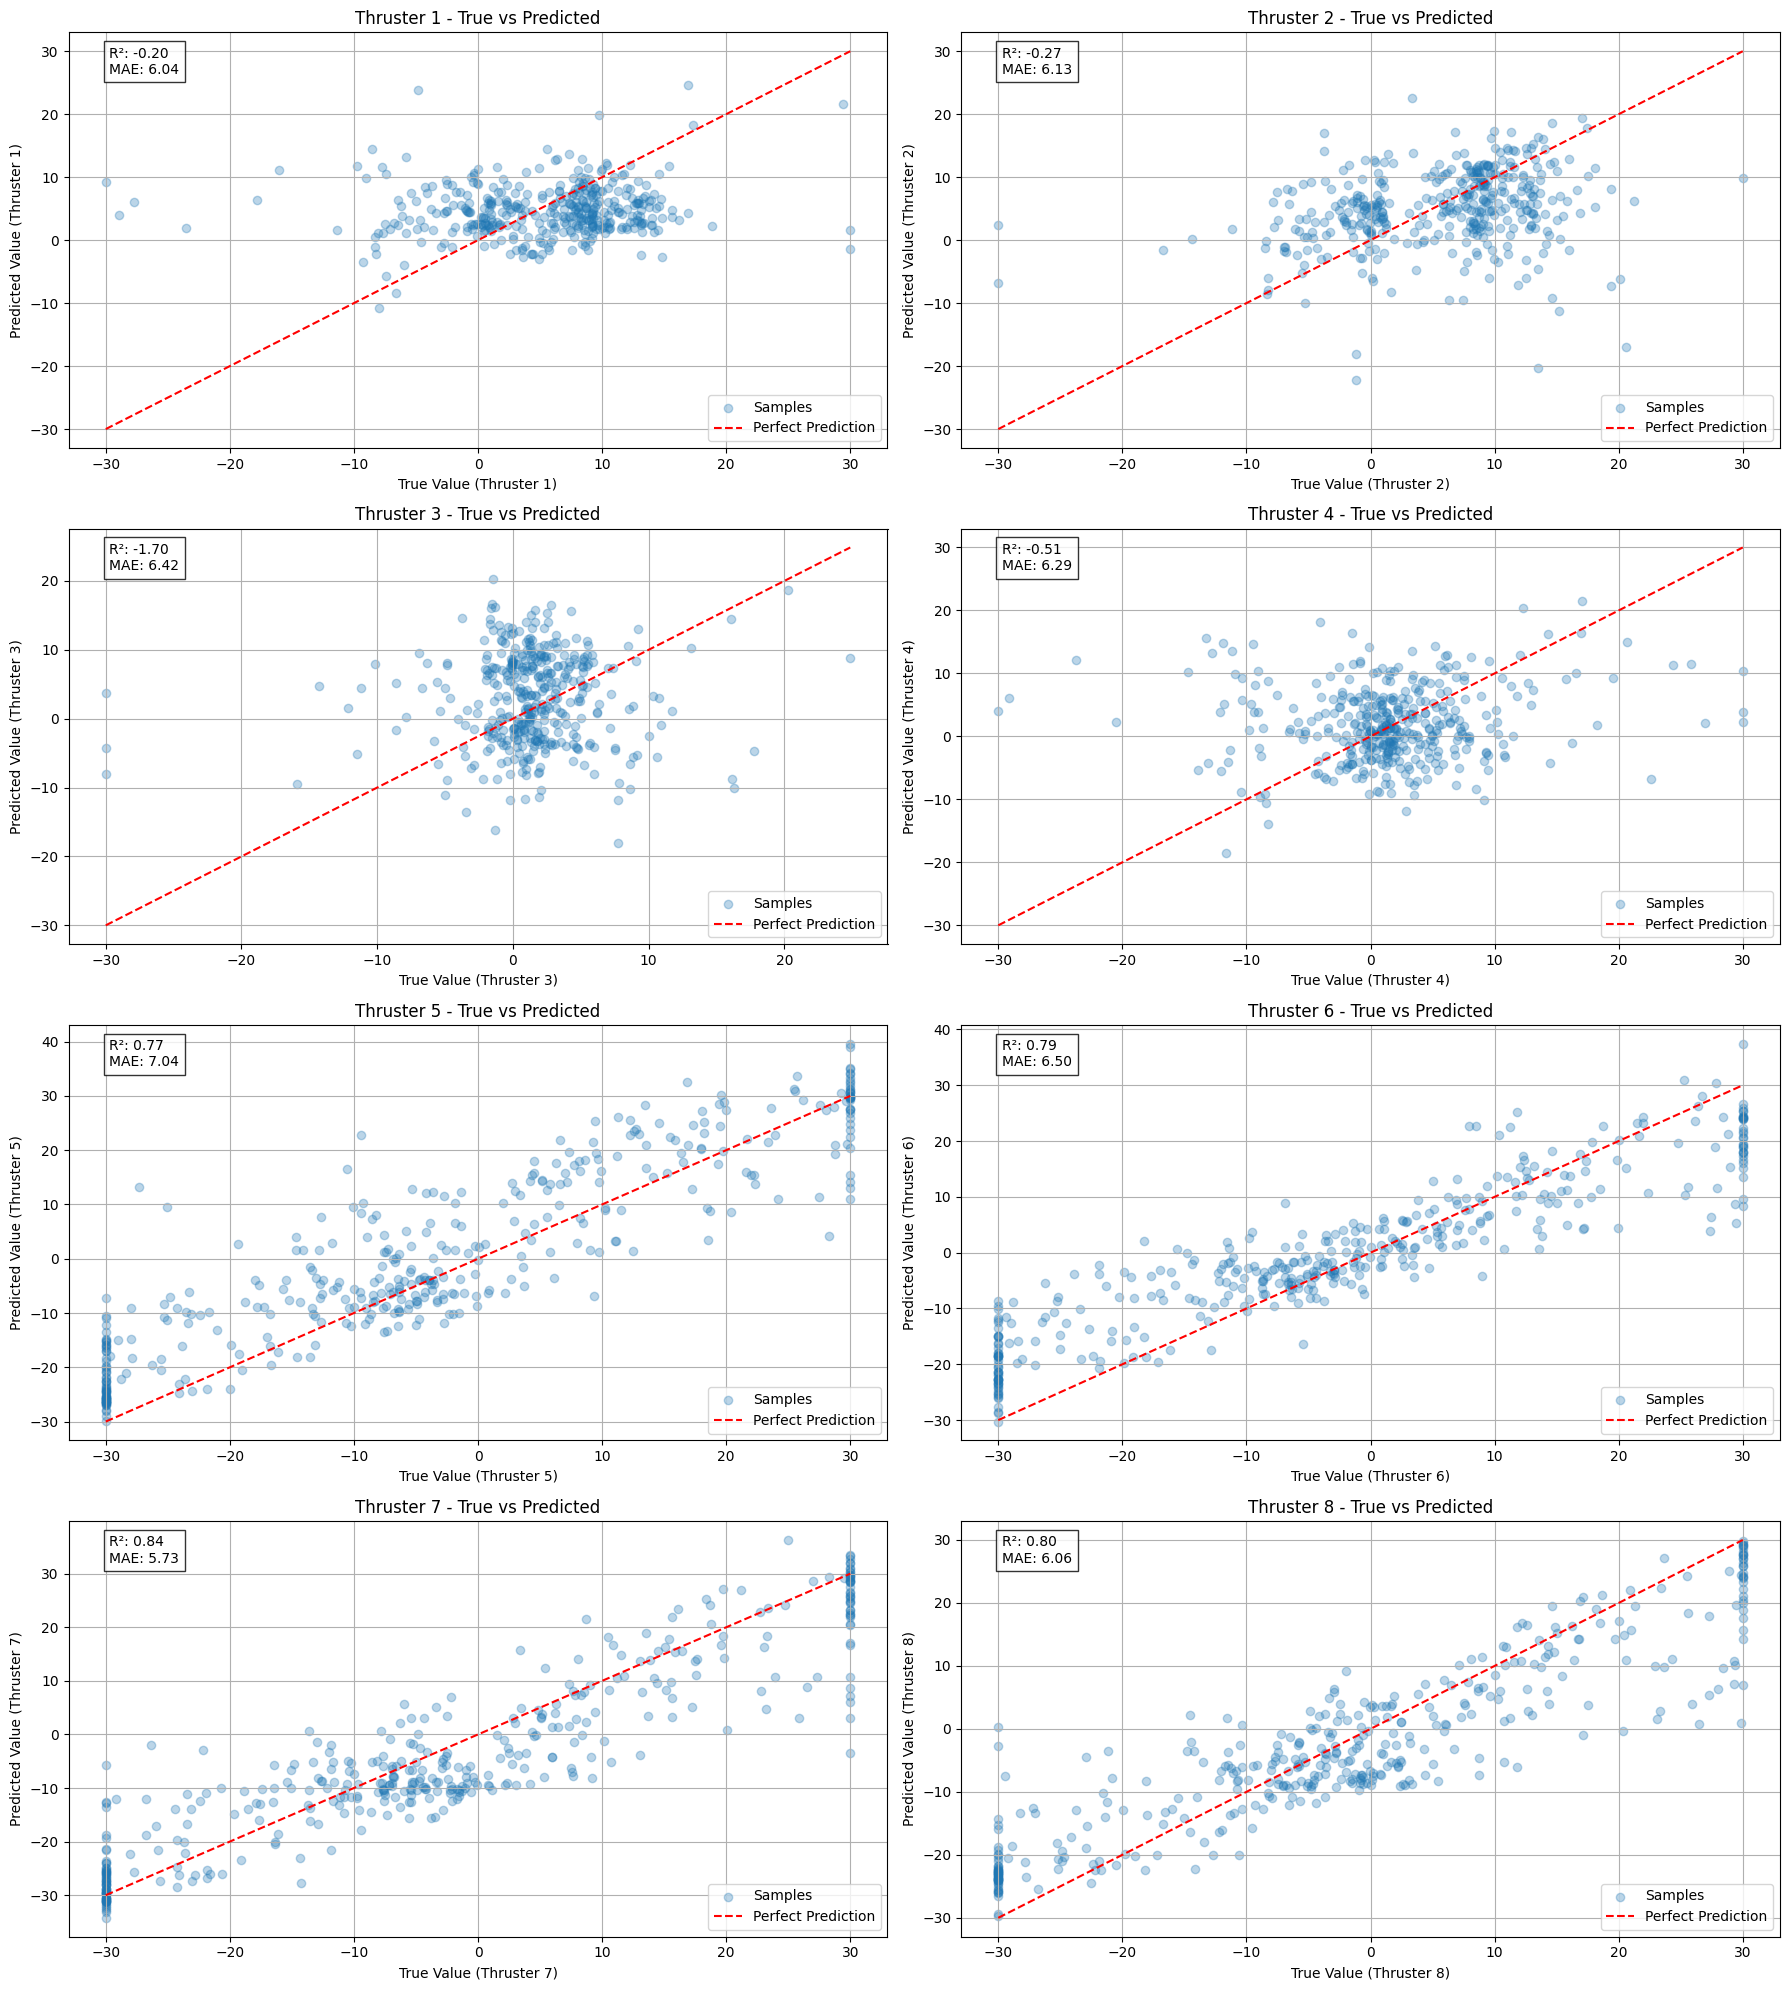

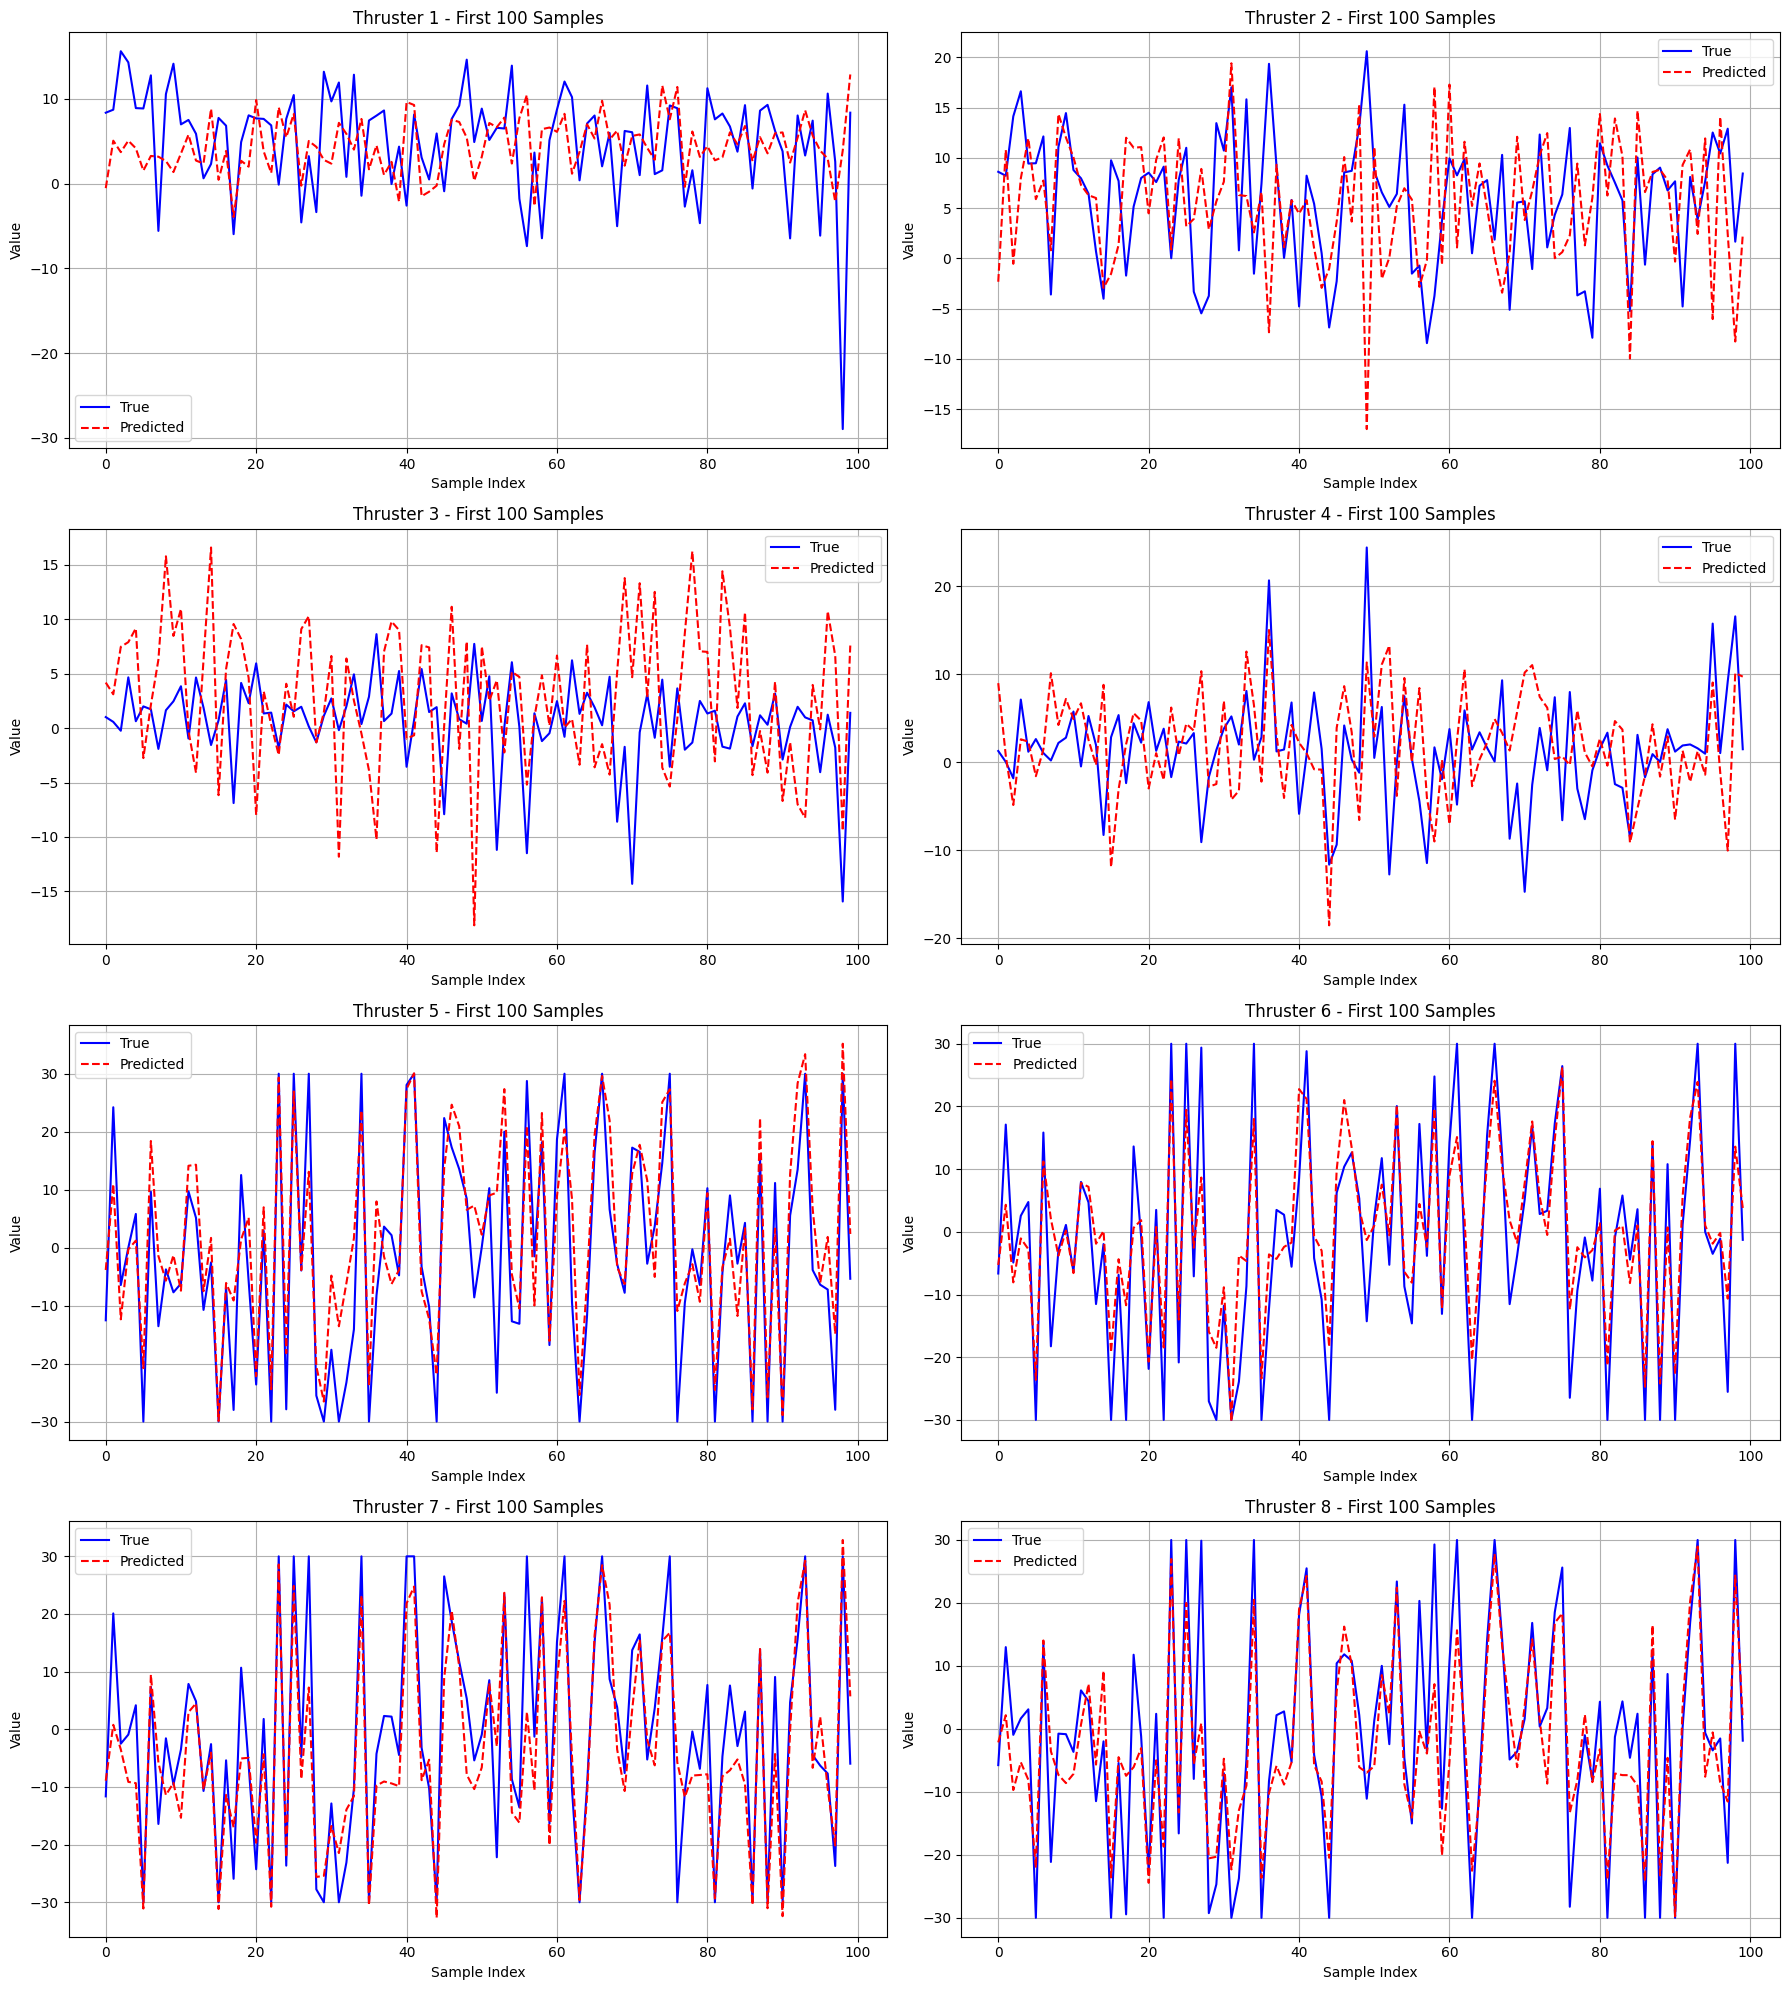

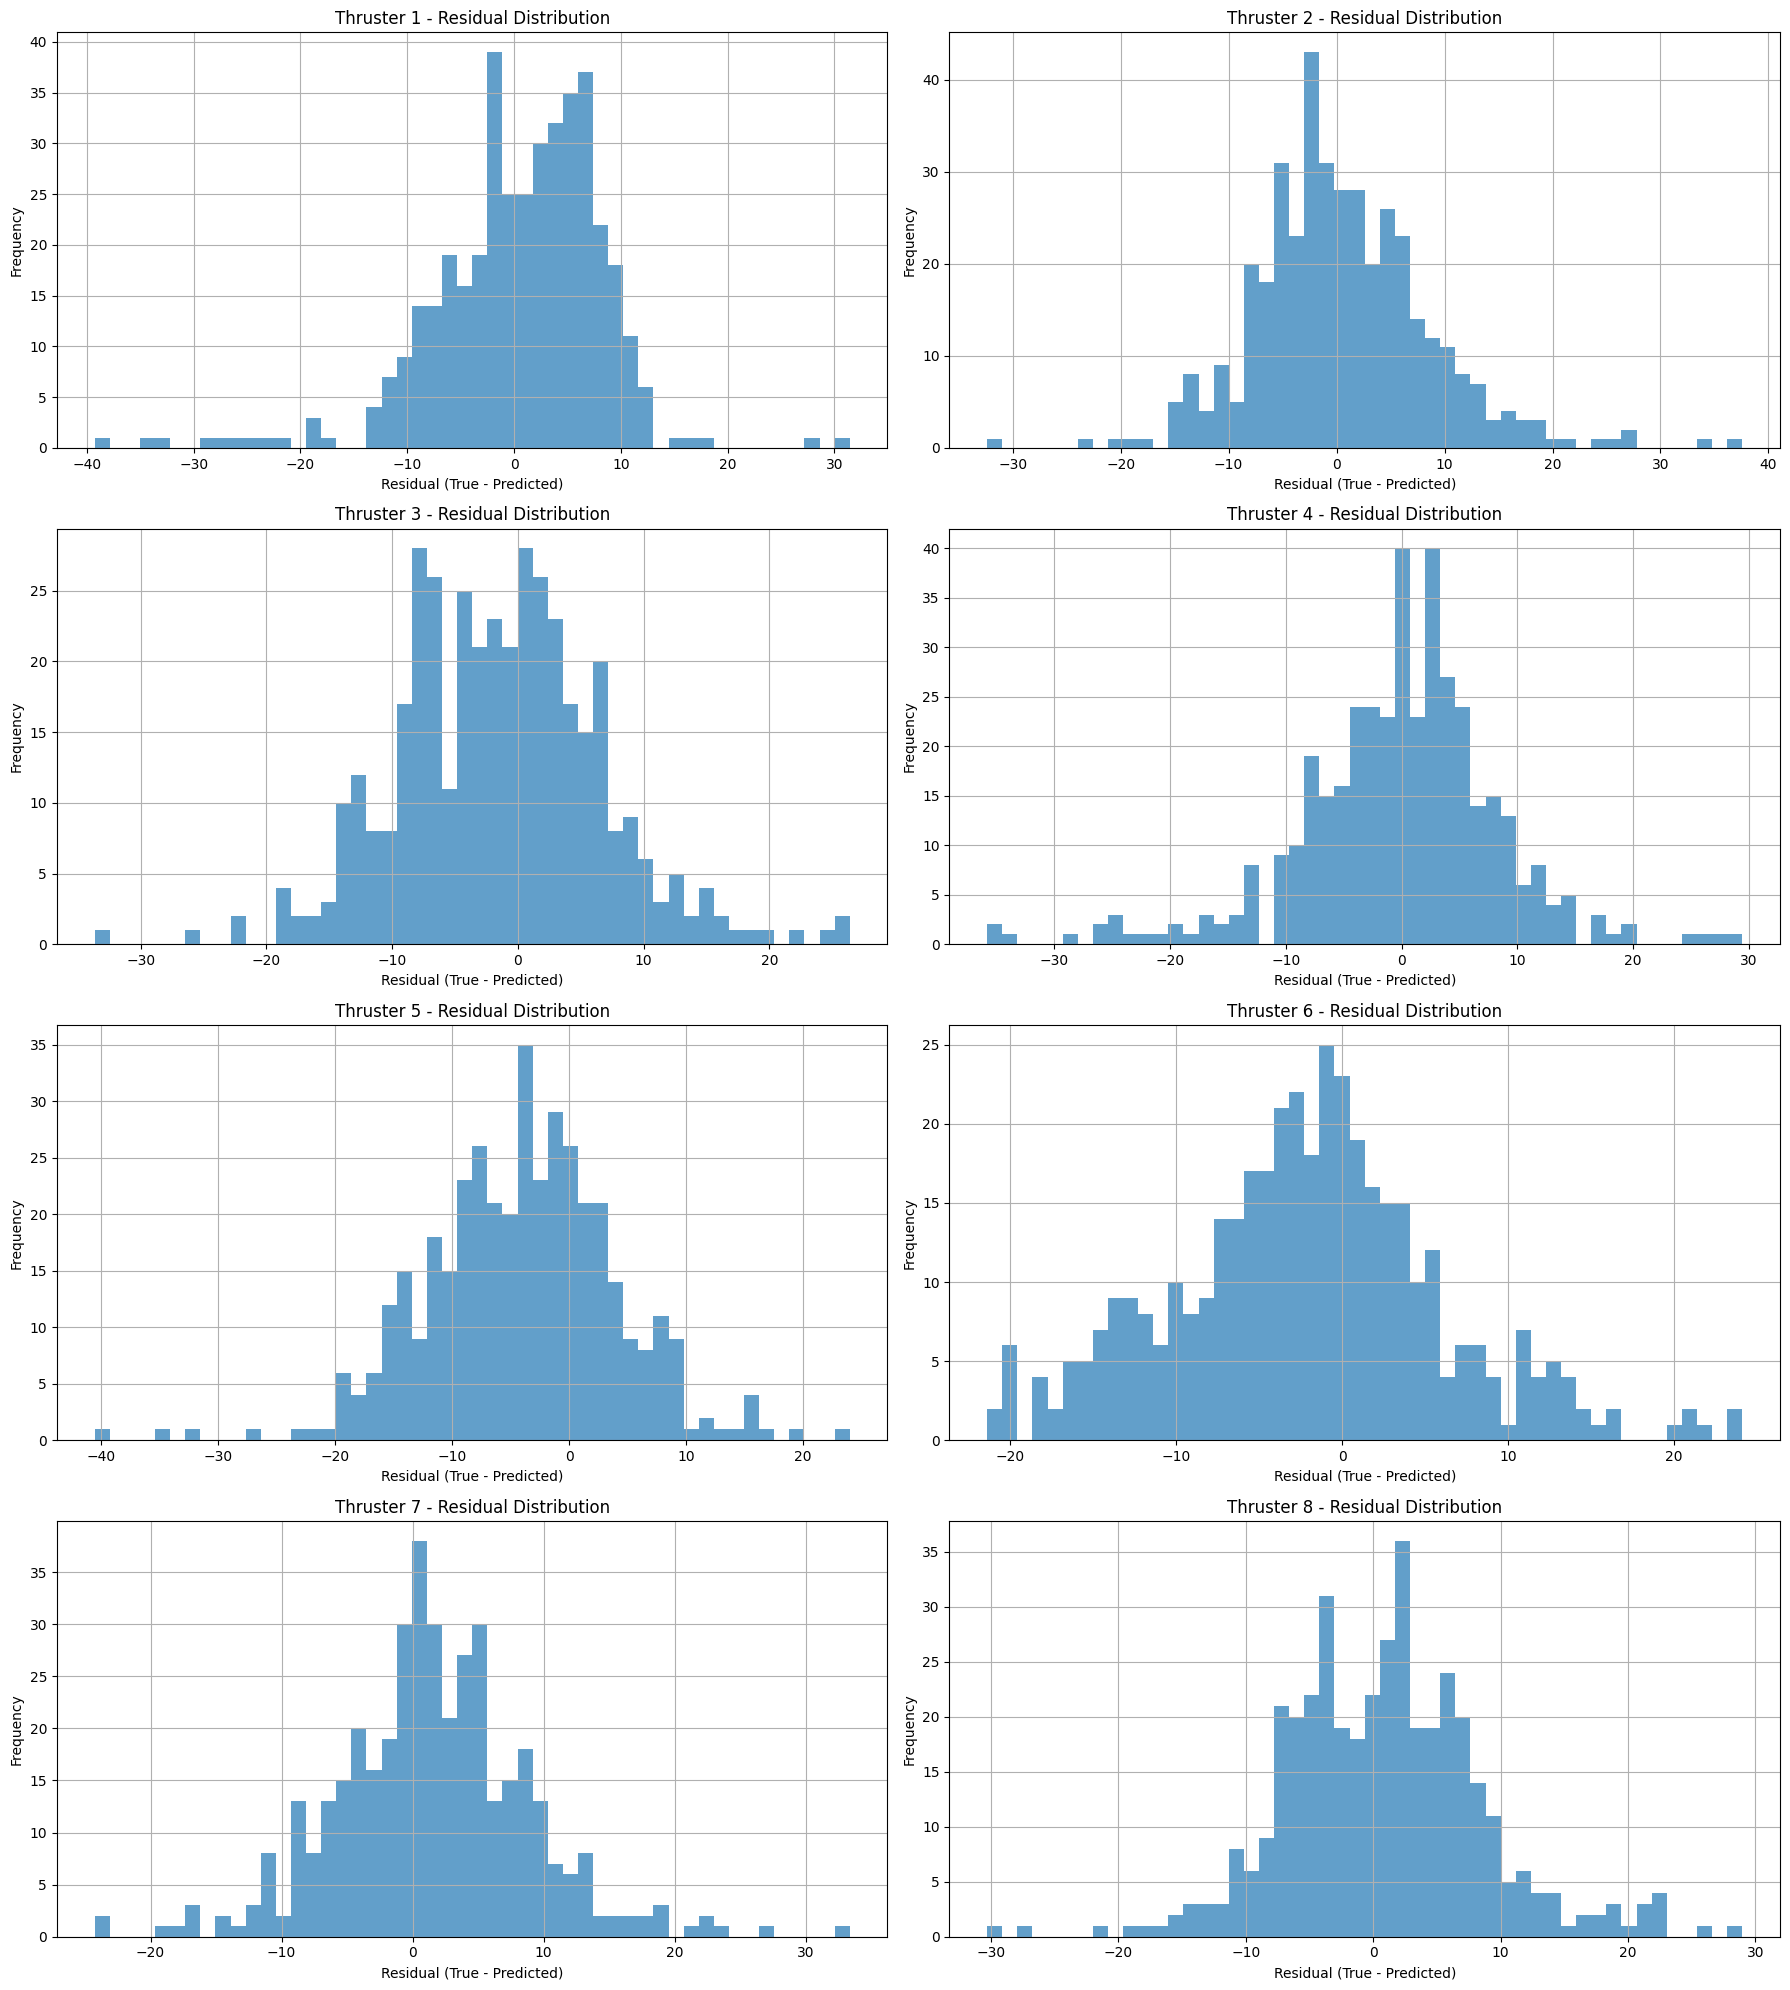

In [14]:
if __name__ == '__main__':
    train()

    # Evaluate on test set
    metrics, thruster_metrics, preds, targets = evaluate_test_set()

    print("\nFinal Test Set Metrics:")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"R²: {metrics['R2']:.4f}")

    print("\nPer-Thruster Metrics:")
    for tm in thruster_metrics:
        print(f"\nThruster {tm['Thruster']}:")
        print(f"MAE: {tm['MAE']:.4f}  MSE: {tm['MSE']:.4f}")
        print(f"RMSE: {tm['RMSE']:.4f}  R²: {tm['R2']:.4f}")

    visualize_results(targets, preds)